## Ising Model Neural Nets
Here, we develop two neural nets which are trained to classify simulation results of the Ising model into "low" and "high" temperature phases.

First we train a neural net with a single hidden layer, an then a convolutional net.

In [1]:
%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

Set the locations training, validation, and test sets.

In [48]:
train_data = '../../data/Ising/train/'
test_data = '../../data/Ising/test/'
valid_data = '../../data/Ising/valid/'

In [3]:
#highTList=os.listdir(train_data+"high")

In [4]:
#class_names = ['low', 'high']

Set up some helper functions to sort the data and labels.

The file name for each simulation is in the form ```phase_Temp_index_.npy``` where ```phase``` is either "high" or "low" and is the label we are training against. We also keep track of the temperature of each simulations, which will allow us to determine the critical phase transition temperature.

In [49]:
def one_hot_label(img):
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,T
def train_data_with_label(train_path,*args):
    train_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(train_path + category)):
                path = os.path.join(train_path, category,i)
                img = np.load(path)
                #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                #img = cv2.resize(img, (128,128))
                train_images.append([img, one_hot_label(i)])
        shuffle(train_images)
        return train_images

def valid_data_with_label(valid_path,*args):
    valid_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(valid_path + category)):
                path = os.path.join(valid_path, category,i)
                img = np.load(path)
                #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                #img = cv2.resize(img, (128,128))
                valid_images.append([img, one_hot_label(i)])
        shuffle(valid_images)
        return valid_images
    

Load in the train and validation sets.

Each element of the sets consists of a tuple of the form: (numpy array, one hot label, temperature)

In [50]:
train_set=train_data_with_label(train_data,'low','high')
valid_set=valid_data_with_label(valid_data,'low','high')

100%|██████████| 1300/1300 [00:00<00:00, 3882.27it/s]


Take a look at a few samples

(array([1, 0]), '2.00')

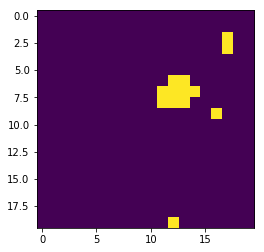

In [51]:
n_test=33
plt.imshow(train_set[n_test][0])
train_set[n_test][1]

Separate the loaded data into arrays containing the image data, label data, and temperature data.

In [52]:
tr_img_data = np.array([i[0] for i in train_set])
tr_lbl_data = np.array([i[1][0] for i in train_set])
tr_Temp_data = np.array([i[1][1] for i in train_set])
val_img_data = np.array([i[0] for i in valid_set])
val_lbl_data = np.array([i[1][0] for i in valid_set])
val_Temp_data = np.array([float(i[1][1]) for i in valid_set])

## Single hidden layer NN
Define the model for a NN with one hidden layer containing $100$ neurons.

In [53]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [54]:
model1.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
model1.fit(x=tr_img_data,y=tr_lbl_data, epochs=20,batch_size=64)

Epoch 1/20
12500/12500 [==============================] - 1s 59us/step - loss: 0.2291 - acc: 0.9111
Epoch 2/20
12500/12500 [==============================] - 0s 35us/step - loss: 0.1746 - acc: 0.9335
Epoch 3/20
12500/12500 [==============================] - 0s 34us/step - loss: 0.1516 - acc: 0.9422
Epoch 4/20
12500/12500 [==============================] - 0s 35us/step - loss: 0.1333 - acc: 0.9477
Epoch 5/20
12500/12500 [==============================] - 0s 35us/step - loss: 0.1227 - acc: 0.9535
Epoch 6/20
12500/12500 [==============================] - 0s 34us/step - loss: 0.1067 - acc: 0.9578
Epoch 7/20
12500/12500 [==============================] - 0s 35us/step - loss: 0.0979 - acc: 0.9630
Epoch 8/20
12500/12500 [==============================] - 0s 35us/step - loss: 0.0872 - acc: 0.9681
Epoch 9/20
12500/12500 [==============================] - 0s 36us/step - loss: 0.0743 - acc: 0.9731
Epoch 10/20
12500/12500 [==============================] - 0s 34us/step - loss: 0.0642 - acc: 0.9776

In [56]:
val_loss, val_acc = model1.evaluate(val_img_data, val_lbl_data)
print('Test accuracy:', val_acc)

2400/2400 [==============================] - 0s 78us/step
Test accuracy: 0.9870833333333333


## Determine the critical temperature
First get the model predictions for the validation set, and separate the outputs for the two neurons in the final layer

In [57]:
predictions=model1.predict(val_img_data)

low_predict = predictions[:,0]
high_predict = predictions[:,1]

Now combine the temperature of the simulations with their predicted phase.

In [58]:
df1 = pd.DataFrame({'pred_low':low_predict,'pred_high':high_predict, 'Temp':val_Temp_data})
df1.head()

,pred_low,pred_high,Temp
0,0.999980,0.000020,1.60
1,0.999918,0.000082,1.80
2,0.999997,0.000003,1.70
3,0.015931,0.984069,2.80
4,0.999811,0.000189,2.15


Find the average (and standard deviation) output of each neuron for each temperature, and plot the results.

In [59]:
df2=df1.groupby('Temp').mean()
df3=df1.groupby('Temp').std()
#df.sort_values(by='Temp')

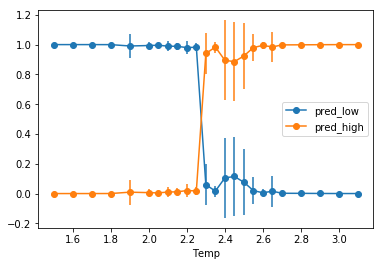

In [60]:
df2.plot(marker='o',yerr=df3)

In [61]:
#plt.plot(val_Temp_data,low_predict,'o')
#plt.plot(val_Temp_data,high_predict,'o')

In [62]:
bad_predictions=[]
for i in range(len(val_lbl_data)):
    #if (low_predict[i]>0.5 and val_lbl_data[i]=='high' and val_Temp_data[i]>=2.6):
    if (low_predict[i]>0.5 and val_Temp_data[i]>=2.6):
        bad_predictions.append(i)

In [63]:
bad_predictions

[1180]

[0 1] 2.9 0.9903442


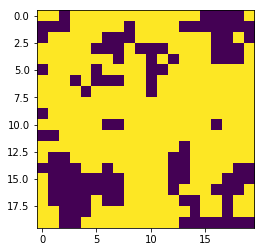

In [28]:
idx=2388
plt.imshow(val_img_data[idx])
print(val_lbl_data[idx],val_Temp_data[idx],low_predict[idx])

IndexError: list index out of range

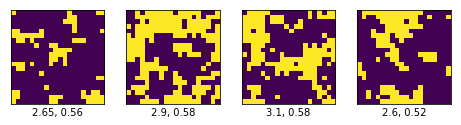

In [212]:
plt.figure(figsize=(10,10))
for i in range(25):
    idx=bad_predictions[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_img_data[idx])
    plt.xlabel(f'{val_Temp_data[idx]}, {low_predict[idx]:.2f}')

In [213]:
#df2.plot(x='Temp',y='pred_low',marker='o')
#df2.plot(x='Temp',y='pred_high',marker='o')

In [214]:
#df2.plot(x='Temp',marker='o',yerr=df3)

## Convolutional Neural Net

In [64]:
tr_img_data = np.array([i[0] for i in train_set]).reshape(-1,20,20,1)
val_img_data = np.array([i[0] for i in valid_set]).reshape(-1,20,20,1)

In [65]:
model2 = keras.Sequential([
    #keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Conv2D(64, (2, 2), input_shape=(20, 20, 1), padding='same'),
    keras.layers.ReLU(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [66]:
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
model2.fit(x=tr_img_data,y=tr_lbl_data, epochs=10,batch_size=64)

Epoch 1/10
12500/12500 [==============================] - 1s 65us/step - loss: 0.0255 - acc: 0.9914
Epoch 2/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0236 - acc: 0.9922
Epoch 3/10
12500/12500 [==============================] - 1s 63us/step - loss: 0.0215 - acc: 0.9928
Epoch 4/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0182 - acc: 0.9931
Epoch 5/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0163 - acc: 0.9947
Epoch 6/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0202 - acc: 0.9930
Epoch 7/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0232 - acc: 0.9906
Epoch 8/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0193 - acc: 0.9933
Epoch 9/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0175 - acc: 0.9934
Epoch 10/10
12500/12500 [==============================] - 1s 62us/step - loss: 0.0147 - acc: 0.9942

In [73]:
val_loss, val_acc = model2.evaluate(val_img_data, val_lbl_data)
print('Test accuracy:', val_acc)

2400/2400 [==============================] - 0s 39us/step
Test accuracy: 0.9845833333333334


In [74]:
predictions2=model2.predict(val_img_data)

low_predict2 = predictions2[:,0]
high_predict2 = predictions2[:,1]

In [75]:
df4 = pd.DataFrame({'pred_low':low_predict2,'pred_high':high_predict2, 'Temp':val_Temp_data})


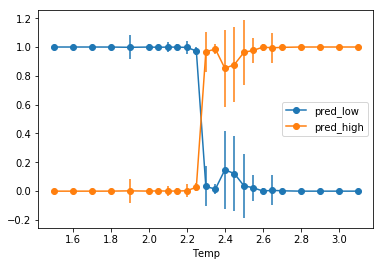

In [76]:
df5=df4.groupby('Temp').mean()
df6=df4.groupby('Temp').std()
df5.plot(marker='o',yerr=df3)

## Test model on triangular lattice simulations

In [77]:
testTri_data = '../../data/Ising/testTri/'

In [79]:
testTri_set=valid_data_with_label(testTri_data,'low','high')
testTri_img_data = np.array([i[0] for i in testTri_set])
testTri_lbl_data = np.array([i[1][0] for i in testTri_set])
testTri_Temp_data = np.array([float(i[1][1]) for i in testTri_set])

100%|██████████| 800/800 [00:00<00:00, 3829.48it/s]


In [85]:
testTri_img_data = np.array([i[0] for i in testTri_set]).reshape(-1,20,20,1)
predictions3=model2.predict(testTri_img_data)

low_predict3 = predictions3[:,0]
high_predict3 = predictions3[:,1]

In [86]:
dfT1 = pd.DataFrame({'pred_low':low_predict3,'pred_high':high_predict3, 'Temp':testTri_Temp_data})


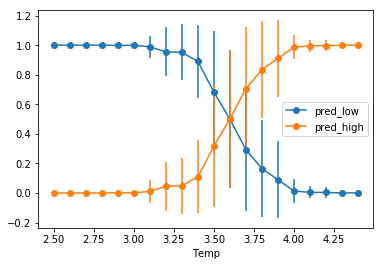

In [87]:
dfT2=dfT1.groupby('Temp').mean()
dfT3=dfT1.groupby('Temp').std()
dfT2.plot(marker='o',yerr=dfT3)